In [ ]:
%matplotlib inline


# Discrete versus Real AdaBoost

This notebook is based on Figure 10.2 from Hastie et al 2009 [1]_ and
illustrates the difference in performance between the discrete SAMME [2]_
boosting algorithm and real SAMME.R boosting algorithm. Both algorithms are
evaluated on a binary classification task where the target Y is a non-linear
function of 10 input features.

Discrete SAMME AdaBoost adapts based on errors in predicted class labels
whereas real SAMME.R uses the predicted class probabilities.

.. [1] T. Hastie, R. Tibshirani and J. Friedman, "Elements of Statistical
    Learning Ed. 2", Springer, 2009.

.. [2] J Zhu, H. Zou, S. Rosset, T. Hastie, "Multi-class AdaBoost",
    Statistics and Its Interface, 2009.


## Preparing the data and baseline models
We start by generating the binary classification dataset
used in Hastie et al. 2009, Example 10.2.



In [1]:
# Authors: Peter Prettenhofer <peter.prettenhofer@gmail.com>,
#          Noel Dawe <noel.dawe@gmail.com>
#
# License: BSD 3 clause

from sklearn import datasets

X, y = datasets.make_hastie_10_2(n_samples=12_000, random_state=1)

Now, we set the hyperparameters for our AdaBoost classifiers.
Be aware, a learning rate of 1.0 may not be optimal for both SAMME and SAMME.R



In [2]:
n_estimators = 400
learning_rate = 1.0

We split the data into a training and a test set.
Then, we train our baseline classifiers, a `DecisionTreeClassifier` with `depth=9`
and a "stump" `DecisionTreeClassifier` with `depth=1` and compute the test error.



In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=2_000, shuffle=False
)

dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)

dt = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1)
dt.fit(X_train, y_train)
dt_err = 1.0 - dt.score(X_test, y_test)

## Adaboost with discrete SAMME and real SAMME.R
We now define the discrete and real AdaBoost classifiers
and fit them to the training set.



In [4]:
from sklearn.ensemble import AdaBoostClassifier

ada_discrete = AdaBoostClassifier(
    estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME",
)
ada_discrete.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=400)

In [5]:
ada_real = AdaBoostClassifier(
    estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME.R",
)
ada_real.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=400)

Now, let's compute the test error of the discrete and
real AdaBoost classifiers for each new stump in `n_estimators`
added to the ensemble.



In [6]:
import numpy as np
from sklearn.metrics import zero_one_loss

ada_discrete_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
    ada_discrete_err[i] = zero_one_loss(y_pred, y_test)

ada_discrete_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
    ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train)

ada_real_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_test)):
    ada_real_err[i] = zero_one_loss(y_pred, y_test)

ada_real_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_train)):
    ada_real_err_train[i] = zero_one_loss(y_pred, y_train)

## Plotting the results
Finally, we plot the train and test errors of our baselines
and of the discrete and real AdaBoost classifiers



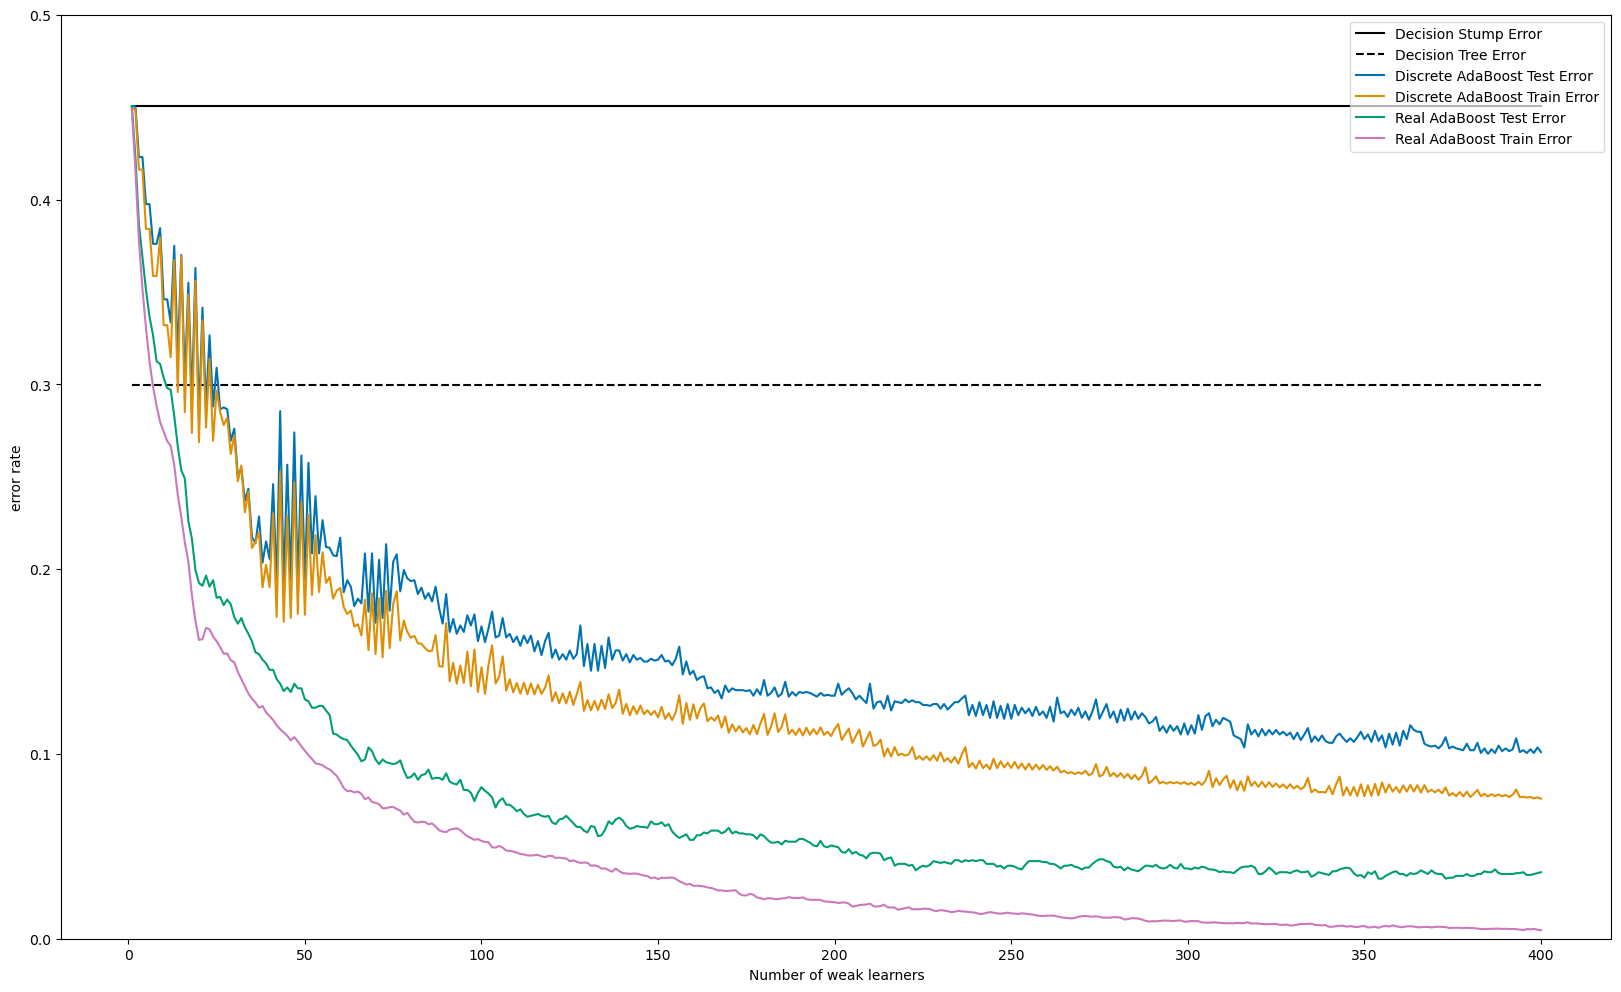

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_stump_err] * 2, "k-", label="Decision Stump Error")
ax.plot([1, n_estimators], [dt_err] * 2, "k--", label="Decision Tree Error")

colors = sns.color_palette("colorblind")

ax.plot(
    np.arange(n_estimators) + 1,
    ada_discrete_err,
    label="Discrete AdaBoost Test Error",
    color=colors[0],
)
ax.plot(
    np.arange(n_estimators) + 1,
    ada_discrete_err_train,
    label="Discrete AdaBoost Train Error",
    color=colors[1],
)
ax.plot(
    np.arange(n_estimators) + 1,
    ada_real_err,
    label="Real AdaBoost Test Error",
    color=colors[2],
)
ax.plot(
    np.arange(n_estimators) + 1,
    ada_real_err_train,
    label="Real AdaBoost Train Error",
    color=colors[4],
)

ax.set_ylim((0.0, 0.5))
ax.set_xlabel("Number of weak learners")
ax.set_ylabel("error rate")

leg = ax.legend(loc="upper right", fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

## Concluding remarks

We observe that the error rate for both train and test sets of real AdaBoost
is lower than that of discrete AdaBoost.

